In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.transforms.functional import adjust_contrast
import matplotlib.pyplot as plt
import random
import glob

In [48]:
from dataset import *

SEED = 8
DATASET_SIZE = 40000

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()

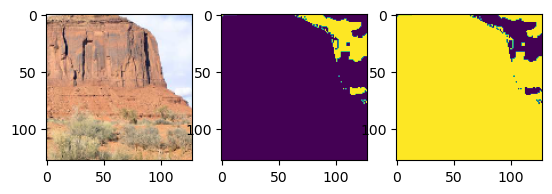

In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    v2.Resize(256),
    v2.RandomCrop(size=(128, 128))
    ])

input_images = glob.glob('data/training/INPUT_IMAGES/*P1.5.JPG')
train_dataset = CorrectionImageDataset(input_images, train=False, transform=transform)
validation_dataset = CorrectionImageDataset('data/validation/GT_IMAGES', train=False, transform=transform)

# test set must be done with the same data 
im, mask = train_dataset[0]

fig, axs = plt.subplots(1,3)
axs[0].imshow(im.permute((1,2,0)))
axs[1].imshow(mask) # Unknown region to generate
axs[2].imshow(~mask) # Known region

In [11]:
len(train_dataset)

3535

In [12]:
len(validation_dataset)

25

# Training the model

In [7]:
from ddpm.ddpm import *
from ddpm.ddpm_train import *

BATCH_SIZE=2
RESIZE_SIZE = 256
IM_SIZE=64


transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    v2.Resize(size=(RESIZE_SIZE, RESIZE_SIZE)),
    v2.RandomCrop(size=(IM_SIZE, IM_SIZE))
    ])

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else None)  
print(f"Model will run on {device}")


input_images = glob.glob('data/training/INPUT_IMAGES/*P1.5.JPG')
train_dataset = CorrectionImageDataset(input_images, train=True, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train(dataloader, device=device, T=250, img_size=IM_SIZE, batch_size=BATCH_SIZE)

Model will run on cuda


10:28:14 - INFO: Starting epoch 1:
  0%|                                                                                         | 0/1768 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)

 km 

tensor(0.)


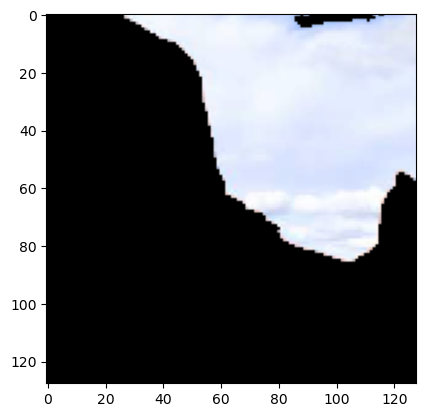

In [50]:
set_seed(SEED)
im, mask = train_dataset[0]


# Apply the mask to all three channels of the image
result = im * mask.unsqueeze(0)
print(result[0,0,0])
plt.imshow(result.permute(1,2,0))
plt.show()